## Multi-model mosaic assessment
Goal: account for efficiency metric sampling uncertainty.

#### Configure the R part of the analysis
This sets up the `gumboot` package.
- https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1029/2020WR029001
- https://cran.r-project.org/web/packages/gumboot/index.html


In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
install.packages("gumboot")
# Note: you will need to select a mirror (i.e., remote location)
#  to download from. This opens in a new popup window on macos.

--- Please select a CRAN mirror for use in this session ---

The downloaded binary packages are in
	/var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T//Rtmp7HlKXX/downloaded_packages


Installing package into ‘/Users/wmk934/Library/R/arm64/4.3/library’
(as ‘lib’ is unspecified)
trying URL 'https://mirror.csclub.uwaterloo.ca/CRAN/bin/macosx/big-sur-arm64/contrib/4.3/gumboot_1.0.1.tgz'
Content type 'text/plain' length 303153 bytes (296 KB)
downloaded 296 KB



In [3]:
%%R
library("gumboot") # loads the package

#### Test the gumboot install
Note: the second code block assumes `ggplot2` and `reshape2` are available on the system. 

In [5]:
%%R
flows_1030500 <- flows_1030500 
head(flows_1030500)

        date      obs      sim
1 1989-10-01 0.753092 1.895452
2 1989-10-02 0.679782 1.738436
3 1989-10-03 0.623800 1.556237
4 1989-10-04 0.582480 1.367636
5 1989-10-05 0.545159 1.185386
6 1989-10-06 0.511836 1.017480


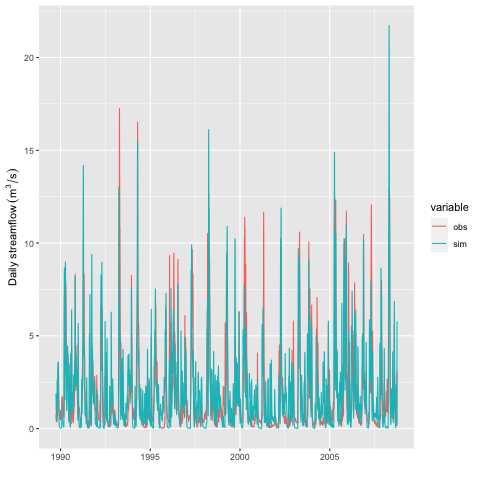

In [6]:
%%R
library(ggplot2)
library(reshape2)
melted <- melt(flows_1030500, id.vars = "date")
ggplot(melted, aes(date, value, colour = variable)) +
  geom_line() +
  xlab("") +
  labs(y = bquote('Daily streamflow'~(m^3/s)), x = "")

In [7]:
%%R
NSE_values <- bootjack(flows_1030500, GOF_stat = "NSE")
NSE_values

  GOF_stat     seJack     seBoot       p05       p50       p95     score
1      NSE 0.04850763 0.04825048 0.4673229 0.5550389 0.6323602 0.5541248
     biasJack      biasBoot      seJab
1 -0.00196514 -0.0003606394 0.04888819


#### Setup
Python packages, file paths, etc.

In [1]:
import geopandas as gpd
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2
import rpy2.robjects as robjects
import xarray as xr

from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from pathlib import Path
from pulp import LpProblem, LpVariable, lpSum, LpMinimize
from rpy2.robjects import pandas2ri
from shapely.geometry import Point

In [2]:
# Gauge meta data - need this for lat/lon
camels_topo = Path('/Users/wmk934/data/camels_us/camels_attributes_v2.0/camels_topo.txt')
camels_flow = Path('/Users/wmk934/data/camels_us/usgs_streamflow/')

# Folder with 'brief analyis' results
brief_folder = Path('/Users/wmk934/data/marrmot_camels_results/')

We'll also add some nation, state, province and territory boundaries (CEC, 2022). This is a pretty hefty download so we'll exclude these files from the repo and simply build in a flag below to not plot the background shapes if they are not available on the system.

**Reference**

Commission for Environmental Cooperation (CEC). 2022. “North American Atlas – Political Boundaries”. Statistics Canada, United States Census Bureau, Instituto Nacional de Estadística y Geografía (INEGI). Ed. 3.0, Vector digital data [1:10,000,000]. Available at http://www.cec.org/north-american-environmental-atlas/political-boundaries-2021/. Accessed 2023-12-20

In [3]:
border_path = '/Users/wmk934/data/CAMELS_spat/camels-spat-data/TEMP_PoliticalBoundaries_Shapefile/NA_PoliticalDivisions/data/bound_p/boundaries_p_2021_v3.shp'

In [4]:
gdf_borders = gpd.read_file(border_path)

In [5]:
# Find CONUS only
gdf_usa = gdf_borders[gdf_borders['COUNTRY'] == 'USA'].copy()
drop_these = ['US-AK', 'US-HI', 'US-PR', 'US-VI']
conus = gdf_usa[~(gdf_usa['STATEABB'].isin(drop_these))].copy()

#### Functions

In [6]:
def get_marrmot_sim_in_mm_d(model_netcdfs, basin, model, of_index=0):  
    
    # Find the file
    qsim_file = [file for file in model_netcdfs if model in file]
    if len(qsim_file) == 1:
        qsim_file = qsim_file[0]
    else:
        print('Case not implemented')
        return

    # Read into dataset
    tmp = xr.open_dataset(qsim_file)

    # Select the basin of interest
    mask = (tmp['Gauge_ID'] == basin)

    # Select the calibrated simulations ( [0]: KGE(Q), [1]: KGE(1/Q), [2]: 0.5*(KGE(Q)+KGE(1/Q)) )
    tmp_sub = tmp['Sim_q'].isel(obj_fn_index=of_index).sel(catchment_index=mask).copy()

    # Store the whole thing in a Pandas Dataframe for easier matching later
    t_start = tmp.attrs['time_calibration_start']
    t_final = tmp.attrs['time_evaluation_end']
    df_tmp = pd.DataFrame(data={'date': pd.date_range(start=t_start, end=t_final, freq='D'),
                                'qsim': tmp_sub.values.flatten()})
    df_tmp.set_index('date', inplace=True)
    
    return df_tmp

In [7]:
def get_camels_obs_in_mm_d(qobs_files, basin, area):

    # Find the file 
    qobs_file = [file for file in qobs_files if f'/{int(basin):08}_' in file]
    if len(qobs_file) == 1:
        qobs_file = qobs_file[0]
    else:
        print('Case not implemented')

    # Read into a dataframe
    tmp = pd.read_csv(qobs_file, header=None)
    tmp = tmp[0].str.split(expand=True)
    tmp = tmp.rename(columns={0: 'gauge_id', 
                          1: 'year', 
                          2: 'month',
                          3: 'day',
                          4: 'qobs',
                          5: 'qc'})

    # Make sure we have the right basin
    assert (tmp['gauge_id'] == f'{int(basin):08}').all(), 'basin ID mismatch'
    
    # Drop the columns we don't need
    tmp = tmp.drop(columns=['gauge_id','qc'])

    # Convert year, month, day columns to datetime index
    tmp['date'] = pd.to_datetime(tmp[['year', 'month', 'day']])
    tmp.set_index('date', inplace=True)
    tmp.drop(columns=['year', 'month', 'day'], inplace=True)

    # Convert the observations to float
    tmp['qobs'] = tmp['qobs'].astype(float)

    # Replace any missing values with NaN, remove negative values
    tmp['qobs'] = tmp['qobs'].replace(-999.0, np.nan)
    tmp[tmp['qobs'] < 0] = np.nan

    # Convert cubic feet per second to mm/day
    m3_per_ft3 = 0.0283168 # [m3 ft-3]
    s_per_d = 86400 # [s day-1]
    m2_per_km2 = 1000000 # [m2 km-2]
    mm_per_m = 1000 # [mm m-1]
    area_m2 = area * m2_per_km2
    tmp['qobs_mm_d'] = tmp['qobs'] * m3_per_ft3 * s_per_d / area_m2 * mm_per_m
    
    return tmp

In [8]:
def kge(obs,sim,invert_flow=False):  

    if invert_flow:
        e = 0.01 * obs.mean() # address zero flow issue; see Knoben et al. (2020;  https://doi.org/10.1029/2019WR025975)
        obs = 1/(obs+e)
        sim = 1/(sim+e)
    
    r = safe_corrcoef(obs,sim)
    a = np.std(sim) / np.std(obs)
    b = np.mean(sim) / np.mean(obs)
    return 1-np.sqrt((r-1)**2 + (a-1)**2 + (b-1)**2)

In [9]:
def safe_corrcoef(x, y):
    # Check if any of the arrays have zero variance (constant)
    if np.var(x) == 0 or np.var(y) == 0:
        return 0 # assume no correlation between both series
        
    # Calculate correlation coefficient
    return np.corrcoef(x, y)[0, 1]

In [10]:
def kge_helper(qobs,qsim,of_index):
    '''Calculates objective function [0]: KGE(Q), [1]: KGE(1/Q), [2]: 0.5*(KGE(Q)+KGE(1/Q))'''
    if of_index == 0:
        return kge(qobs,qsim)
    elif of_index == 1:
        return kge(qobs,qsim,invert_flow=True)
    elif of_index == 2:
        return 0.5*(kge(qobs,qsim) + kge(qobs,qsim,invert_flow=True))
    else:
        print('Case not implemented.')
        return

In [11]:
def min_set_cover(universal_set, subsets):

    '''Selects the minimum number of subsets needed to cover all elements in universal set

    Inputs:
    - universal_set: set with all elements, e.g. {'A','B','C'}
    - subsets: list with all subsets, e.g. [{'A'},{'B'},{'C'},{'A','B'}]

    Outputs:
    - len(selected_subsets): number of subsets needed to cover universal_set, e.g. 2
    - selected_indices: indices of selected subsets, e.g. [2,3]
    - selected_subsets: subsets needed to cover universal_set as tuples, e.g. [('C'),('A','B')]
    '''
    
    # Convert sets to tuples
    subsets = [tuple(s) for s in subsets]

    # Create a binary variable for each subset indicating if it's chosen or not
    chosen = LpVariable.dicts("chosen", subsets, cat='Binary')

    # Create the set cover problem
    prob = LpProblem("SetCover", LpMinimize)

    # Objective function: minimize the number of chosen subsets
    prob += lpSum(chosen[s] for s in subsets)

    # Constraint: ensure that each element in the universal set is covered
    for element in universal_set:
        prob += lpSum(chosen[s] for s in subsets if element in s) >= 1

    # Solve the problem
    prob.solve()

    # Extract the selected subsets and their indices
    selected_subsets = [s for s in subsets if chosen[s].varValue == 1]
    selected_indices = [subsets.index(s) for s in selected_subsets]

    return len(selected_subsets), selected_indices, selected_subsets

In [12]:
def sort_selected_subsets_by_coverage(all_basins, selected_subsets, selected_models, match_output_to_existing=False):

    '''Sorts min_set_cover output for plotting'''
    
    # Prep
    remaining_basins = all_basins.copy() # Start with a full list of basins that all still need a model assigned to them
    remaining_subsets= selected_subsets.copy() # Start with all selected subsets
    remaining_models = selected_models.copy() # Start with all selected models
    sorted_models = []
    basins_filled = []

    # Sorted by coverage
    while len(remaining_basins) > 0:
    
        # Find how many of the remaining basins each remaining subsets covers
        basins_covered = []
        for subset in remaining_subsets:
            basins_covered.append(len(set(remaining_basins) & set(subset)))
    
        # Find the model that covers the most of these basins and how many basins that is
        num_basins = max(basins_covered)
        model = remaining_models[basins_covered.index(max(basins_covered))]

        # Find the model that covers the most of these basins and how many basins that is
        num_basins = max(basins_covered)
        idx_to_use = basins_covered.index(max(basins_covered))
        model = remaining_models[idx_to_use]

        # Update the "remaining_" variables
        remaining_basins -= set(remaining_subsets[idx_to_use])
        remaining_models.pop(idx_to_use); # w/o ";" we return the popped value
        remaining_subsets.pop(idx_to_use);

        # Update the outputs
        sorted_models.append(model)
        basins_filled.append(num_basins)

    # Fix up output if needed
    if match_output_to_existing:
        sorted_models = [f"{m}_above_p5" for m in sorted_models]
        basins_filled = [np.int64(v) for v in basins_filled]
    
    return sorted_models, basins_filled

#### File locations

In [13]:
# Define the output folder for the CSVs
csv_folder = Path('./csv_files')
csv_folder.mkdir(parents=True, exist_ok=True)

# Processing of inputs
csv_topo_name = 'camels_topo.csv'
csv_qobs_name = 'camels_qobs.csv'

# Processing of existing results
csv_qsim_name = 'camels_qsim_of{}.csv'
csv_score_name= 'camels_scores_of{}.csv'
csv_model_name= 'camels_marrmot_models.csv'
csv_gauge_name= 'camels_marrmot_gauges.csv'

# Calculation of gumboot stats for each Objective function case
csv_gumboot_name = 'gumboot_results_of{}.csv'

# Define the output folder for the images
img_folder = Path('./img')
img_kge_reg_folder = img_folder / 'kge_regular'
img_kge_low_folder = img_folder / 'kge_low_flows'
img_kge_reg_folder.mkdir(parents=True, exist_ok=True)
img_kge_low_folder.mkdir(parents=True, exist_ok=True)

#### Data processing
Here we'll create CSV files of Qobs and the three different simulations, as well as gauge location and area.

##### Topo

In [14]:
# Get the gauge location and areas
df = pd.read_csv(camels_topo, delimiter=';',usecols=['gauge_id', 'gauge_lat', 'gauge_lon', 'area_gages2', 'area_geospa_fabric']).set_index('gauge_id')
df.to_csv(csv_folder/csv_topo_name)

##### Qobs

In [20]:
# Find the streamflow files
qobs_files = []
for huc in range(1,19):
    qobs_files += glob.glob(str(camels_flow / f'{huc:02}' / '*.txt'))

In [21]:
# Make the dataframe with observations
qobs_all = []
for basin,row in df.iterrows():
    qobs = get_camels_obs_in_mm_d(qobs_files, basin, row['area_gages2'])
    qobs.drop(columns={'qobs'}, inplace=True)
    qobs.rename(columns={'qobs_mm_d': basin}, inplace=True)
    qobs_all.append(qobs)
qobs_all = pd.concat(qobs_all, axis=1)

In [22]:
qobs_all.to_csv(csv_folder/csv_qobs_name)

##### Qsim for all three objective functions

In [15]:
# Find the model result files
model_netcdfs = sorted( glob.glob( str(brief_folder/'*.nc') ) )

In [24]:
# For each objective function... 
for of_index in range(0,3):
    print(f"--- Running OF {of_index}")

    # Prepare for this loop
    df_thisOF = df.copy()
    model_names = []
    model_ids = []
    columns_cal = []
    columns_val = []
    
    # ... loop over the model files, extract Qsim and calculate the objective function values, and save as CSV
    for model_netcdf in model_netcdfs:
    
        # Lazy-load the netcdf
        data = xr.open_dataset(model_netcdf)
    
        # Determine model ID so we can use that in the dataframe column names
        model_name = data.attrs['model_name']
        model_id = f'm{model_name[2:4]}'
        model_names.append(model_name)
        model_ids.append(model_id)
        print(f'Running model {model_id}: {model_name}') 
    
        # Calculate the KGE scores
        cal_s = data.attrs['time_calibration_start']
        cal_e = data.attrs['time_calibration_end']
        val_s = data.attrs['time_evaluation_start']
        val_e = data.attrs['time_evaluation_end']
    
        qsim = data['Sim_q'].sel(obj_fn_index=of_index) # grab the right OF (0: KGE(Q), 1: KGE(1/Q), 2: 0.5*(KGE(Q)+KGE(1/Q)))
        qsim_all = qsim.to_dataframe().reset_index(level=1).pivot(columns='catchment_index')
        qsim_all.index = pd.date_range(start=cal_s, end=val_e, freq='D')
        qsim_all.columns = qsim_all.columns.droplevel()
        new_column_names = {old_name: new_name for old_name, new_name in zip(qsim_all.columns, data['Gauge_ID'].values)}
        qsim_all = qsim_all.rename(columns=new_column_names)
    
        kges_c = []
        kges_v = []
        basins = []
        for column in qsim_all.columns:
    
            # 1. Get the time series
            qsim = qsim_all[column]
            qobs = qobs_all[column]
    
            # 2. Subset to cal and val only
            qobs_cal = qobs[(qobs.index >= cal_s) & (qobs.index <= cal_e)]
            qsim_cal = qsim[(qsim.index >= cal_s) & (qsim.index <= cal_e)]
            qobs_val = qobs[(qobs.index >= val_s) & (qobs.index <= val_e)]
            qsim_val = qsim[(qsim.index >= val_s) & (qsim.index <= val_e)]
    
            # 3. Ensure that if qobs is missing some values we subset things a bit again
            qsim_cal = qsim_cal[qsim_cal.index.isin(qobs_cal.index)] # Ensure missing dates are removed
            qsim_cal = qsim_cal[~qobs_cal.isnull()] # Ensure NaNs are removed from both
            qobs_cal = qobs_cal[~qobs_cal.isnull()]
    
            qsim_val = qsim_val[qsim_val.index.isin(qobs_val.index)] # Ensure missing dates are removed
            qsim_val = qsim_val[~qobs_val.isnull()] # Ensure NaNs are removed from both
            qobs_val = qobs_val[~qobs_val.isnull()]
    
            # 4. Calculate the scores
            kge_cal = kge_helper(qobs_cal,qsim_cal,of_index)
            kge_val = kge_helper(qobs_val,qsim_val,of_index)
    
            # 5. Keep track
            basins.append(column)
            kges_c.append(kge_cal)
            kges_v.append(kge_val)
    
        # Make a temporary dataframe that we'll later merge with the main one
        column_cal = f'{model_id}_cal_kge'
        column_val = f'{model_id}_val_kge'
        df_tmp = pd.DataFrame(
                              data={
                                    'gauge_id': basins,
                                    column_cal: kges_c,
                                    column_val: kges_v
                                    }
                             )
        df_tmp = df_tmp.set_index('gauge_id')
        columns_cal.append(column_cal)
        columns_val.append(column_val)
    
        # Combine the two dataframes using GAGE IDs as indices, keeping the full list of IDs (even those we don't have model results for)
        df_thisOF = pd.merge(df_thisOF,df_tmp, left_index=True, right_index=True, how='left')

    # Save the simulation scores
    df_thisOF.to_csv(csv_folder/csv_score_name.format(of_index))
    
# Create a legend for later use
model_legend = pd.DataFrame(data={'model_name': model_names,'model_id': model_ids})
model_legend.to_csv(csv_folder/csv_model_name)
    
# Save the list of gauges used in the MARRMoT runs
marrmot_gauges = data['Gauge_ID']
marrmot_gauges.to_dataframe().to_csv(csv_folder/csv_gauge_name)

--- Running OF 0
Running model m01: m_01_collie1_1p_1s
Running model m02: m_02_wetland_4p_1s
Running model m03: m_03_collie2_4p_1s
Running model m04: m_04_newzealand1_6p_1s
Running model m05: m_05_ihacres_6p_1s
Running model m06: m_06_alpine1_4p_2s
Running model m07: m_07_gr4j_4p_2s
Running model m08: m_08_us1_5p_2s
Running model m09: m_09_susannah1_6p_2s
Running model m10: m_10_susannah2_6p_2s
Running model m11: m_11_collie3_6p_2s
Running model m12: m_12_alpine2_6p_2s
Running model m13: m_13_hillslope_7p_2s
Running model m14: m_14_topmodel_7p_2s
Running model m15: m_15_plateau_8p_2s
Running model m16: m_16_newzealand2_8p_2s
Running model m17: m_17_penman_4p_3s
Running model m18: m_18_simhyd_7p_3s
Running model m19: m_19_australia_8p_3s
Running model m20: m_20_gsfb_8p_3s
Running model m21: m_21_flexb_9p_3s
Running model m22: m_22_vic_10p_3s
Running model m24: m_24_mopex1_5p_4s
Running model m25: m_25_tcm_6p_4s
Running model m26: m_26_flexi_10p_4s
Running model m27: m_27_tank_12p_4s
Run

#### Calculate uncertainty

In [35]:
# Load the static results
model_legend = pd.read_csv(csv_folder/csv_model_name,index_col=0)
marrmot_gauges = xr.DataArray(pd.read_csv(csv_folder/csv_gauge_name, index_col=0)['Gauge_ID'])

In [34]:
# Specify some settings we would normally get as a natural consequence of running all code blocks in order
# Hard-coding them here helps if we need to restart the analysis halfway through

# Time periods
cal_s = '1989-01-01'
cal_e = '1998-12-31'
val_s = '1999-01-01'
val_e = '2009-12-31'

# Cal and val column names
columns_cal = ['m01_cal_kge', 'm02_cal_kge', 'm03_cal_kge', 'm04_cal_kge', 'm05_cal_kge', 'm06_cal_kge', 'm07_cal_kge', 'm08_cal_kge', 'm09_cal_kge', 
               'm10_cal_kge', 'm11_cal_kge', 'm12_cal_kge', 'm13_cal_kge', 'm14_cal_kge', 'm15_cal_kge', 'm16_cal_kge', 'm17_cal_kge', 'm18_cal_kge', 
               'm19_cal_kge', 'm20_cal_kge', 'm21_cal_kge', 'm22_cal_kge', 'm24_cal_kge', 'm25_cal_kge', 'm26_cal_kge', 'm27_cal_kge', 'm28_cal_kge', 
               'm29_cal_kge', 'm30_cal_kge', 'm31_cal_kge', 'm32_cal_kge', 'm34_cal_kge', 'm35_cal_kge', 'm36_cal_kge', 'm37_cal_kge', 'm40_cal_kge']
columns_val = ['m01_val_kge', 'm02_val_kge', 'm03_val_kge', 'm04_val_kge', 'm05_val_kge', 'm06_val_kge', 'm07_val_kge', 'm08_val_kge', 'm09_val_kge', 
               'm10_val_kge', 'm11_val_kge', 'm12_val_kge', 'm13_val_kge', 'm14_val_kge', 'm15_val_kge', 'm16_val_kge', 'm17_val_kge', 'm18_val_kge',
               'm19_val_kge', 'm20_val_kge', 'm21_val_kge', 'm22_val_kge', 'm24_val_kge', 'm25_val_kge', 'm26_val_kge', 'm27_val_kge', 'm28_val_kge', 
               'm29_val_kge', 'm30_val_kge', 'm31_val_kge', 'm32_val_kge', 'm34_val_kge', 'm35_val_kge', 'm36_val_kge', 'm37_val_kge', 'm40_val_kge']

In [27]:
# Loop over the different results CSVs
# NOTE: we can only run for obejctive function 0 ( KGE(Q) ) and 1 ( KGE(1/Q) )
# We cannot run for OF2 ( 0.5*(KGE(Q) + KGE(1/Q)) ), because gumboot does not
# let us specify our own objective functions. We can calculate the uncertainty
# of the scores with inverted flows, but we cannot calculate the uncertainty of
# the combined objective function
kge_checks_p = []
kge_checks_r = []
for of_index in range(0,2):

    # --- Prep
    # Load the results into a dataframe
    csv_file = csv_score_name.format(of_index)
    df = pd.read_csv(csv_folder/csv_file, index_col=0)

    # Subset the dataframe to only those basins for which we have model results (559 basins)
    df_sub = df.loc[df.index.isin(marrmot_gauges.values)].copy()

    # For each basin, find which model is best during validation
    df_sub['best_eval_column'] = df_sub[columns_val].idxmax(axis=1)
    df_sub['best_eval_model'] = 'm_' + df_sub['best_eval_column'].str[1:3] # convert to something usable for searching the netcdf files with simulations
    df_sub['best_eval_score'] = df_sub[columns_val].max(axis=1)

    # Add the gumboot columns
    gumboot_cols = ['GOF_stat', 'seJack', 'seBoot', 'p05', 'p50', 'p95', 'score', 'biasJack', 'biasBoot', 'seJab']
    for col in gumboot_cols:
        tmp_val = -999.0
        if col == 'GOF_stat':
            tmp_val = 'n/a' # needs this to make the later df_sub.update(results) work w/ different datatypes
        df_sub[col] = tmp_val

    # --- Run gumboot
    print(f'Running objective function {of_index} with {val_s} to {val_e}')

    # Loop over the basins and
    # 1. Extract the observations, and convert to mm/day
    # 2. Extract simulations for the best model
    # 3. Subset both time series to the evaluation period only
    # 4. Deal with NaNs in the observations
    # 5. [OPTIONAL] Transform flows
    # 6. Transfer to R
    # 7. Run gumboot to get KGE uncertainty
    # 8. Transfer to python
    # 9. Store uncertainty in dataframe
    
    for basin,row in df_sub.iterrows():
    
        print(f'Running {basin}')
        
        # 1. Get the observations
        qobs = get_camels_obs_in_mm_d(qobs_files, basin, row['area_gages2'])
    
        # 2. Extract simulations for the best model
        qsim = get_marrmot_sim_in_mm_d(model_netcdfs, basin, row['best_eval_model'], of_index=of_index)
    
        # 3. Subset both time series to the evaluation period only
        qobs_sub = qobs[(qobs.index >= val_s) & (qobs.index <= val_e)]
        qsim_sub = qsim[(qsim.index >= val_s) & (qsim.index <= val_e)]
    
        # 4. Now ensure that if qobs is missing some values we subset things a bit again
        qsim_sub = qsim_sub[qsim_sub.index.isin(qobs_sub.index)] # Ensure missing dates are removed

        # 5. If of_index == 1 (KGE(1/Q)), add the error factor and invert the flows
        if of_index == 1:
            e = 0.01 * qobs_sub['qobs_mm_d'].mean()
            qobs_sub.loc[:,'qobs_mm_d'] = 1 / (qobs_sub['qobs_mm_d'] + e)
            qsim_sub['qsim'] = 1 / (qsim_sub['qsim'] + e)
    
        # 6. Move variables to R
        to_R = qobs_sub.merge(qsim_sub, left_index=True, right_index=True)
        to_R.drop(columns=['qobs'], inplace=True) # original USGS column in ft3 s-1
        to_R.rename(columns={'qobs_mm_d': 'obs', 'qsim': 'sim'}, inplace=True)
        robjects.globalenv['date_strings'] = robjects.StrVector( to_R.index.strftime('%Y-%m-%d').tolist() )
        robjects.globalenv['obs'] = robjects.FloatVector(to_R['obs'].values)
        robjects.globalenv['sim'] = robjects.FloatVector(to_R['sim'].values)
    
        # 7. Run gumboot
        robjects.r('''
            # Create date vector
            dates <- as.Date(date_strings, format = "%Y-%m-%d")
            
            # Build dataframe for gumboot
            foot <- data.frame(
              date = dates,
              obs = obs,
              sim = sim
            )
        
            clean_foot <- na.omit(foot)
        
            # Run gumboot, catching errors if needed
            result <- try({
                result <- bootjack(clean_foot, GOF_stat = "KGE", seed = 1)
            })
        
            # Check if we encountered an error, and return all NaNs if so
            if (inherits(result, "try-error")) {
              print("An error occurred, returning all NaNs")
              result <- data.frame(
                  GOF_stat = NA, # This one ion particular may be helpful for later filtering
                  seJack = NA,
                  seBoot = NA,
                  p05 = NA,
                  p50 = NA,
                  p95 = NA,
                  score = NA,
                  biasJack = NA,
                  biasBoot = NA,
                  seJab = NA
                )
            }
        ''')
    
        # 8. Move results into Python
        from_R = robjects.r['result']
        with (robjects.default_converter + pandas2ri.converter).context():
            results = robjects.conversion.get_conversion().rpy2py(from_R) # Pandas dataframe w/ gumboot columns and default index
            results = results.replace(-2147483648, np.nan)
        results['gauge_id'] = basin
        results = results.set_index('gauge_id') # set the index used in df_sub
    
        # 9. Store results in lists that we'll later add to the dataframe
        df_sub.update(results)

    # 10. Save the results to csv
    df_sub.to_csv(csv_folder/csv_gumboot_name.format(of_index))

Running objective function 0 with 1999-01-01 to 2009-12-31
Running 1013500.0
Running 1022500.0
Running 1030500.0
Running 1031500.0
Running 1047000.0
Running 1052500.0
Running 1054200.0
Running 1055000.0
Running 1057000.0
Running 1073000.0
Running 1078000.0
Running 1123000.0
Running 1134500.0
Running 1137500.0
Running 1139000.0
Running 1139800.0
Running 1142500.0
Running 1144000.0
Running 1169000.0
Running 1170100.0
Running 1181000.0
Running 1187300.0
Running 1195100.0
Running 1333000.0
Running 1350000.0
Running 1350080.0
Running 1365000.0
Running 1411300.0
Running 1413500.0
Running 1414500.0
Running 1415000.0
Running 1423000.0
Running 1434025.0
Running 1435000.0
Running 1439500.0
Running 1440000.0
Running 1440400.0
Running 1451800.0
Running 1487000.0
Running 1491000.0
Running 1510000.0
Running 1516500.0
Running 1518862.0
Running 1532000.0
Running 1539000.0
Running 1542810.0
Running 1543000.0
Running 1543500.0
Running 1544500.0
Running 1545600.0
Running 1547700.0
Running 1548500.0
Runni

R[write to console]: Error in quantile.default(xSample, 0.05, type = 3) : 
  missing values and NaN's not allowed if 'na.rm' is FALSE

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In cor(qSimValid, qObsValid) :
R[write to console]:  the standard deviation is zero



[1] "An error occurred, returning all NaNs"
Running 6447000.0
Running 6447500.0
Running 6450500.0
Running 6452000.0
Running 6453600.0
Running 6464500.0
Running 6468170.0
Running 6468250.0
Running 6470800.0
Running 6477500.0
Running 6479215.0
Running 6601000.0
Running 6614800.0
Running 6622700.0
Running 6623800.0
Running 6632400.0
Running 6784000.0
Running 6803510.0
Running 6803530.0
Running 6814000.0
Running 6847900.0
Running 6853800.0
Running 6876700.0
Running 6878000.0
Running 6879650.0
Running 6885500.0
Running 6888500.0
Running 6889200.0
Running 6889500.0
Running 6892000.0
Running 6903400.0
Running 6906800.0
Running 6910800.0
Running 6911900.0
Running 6917000.0
Running 6918460.0
Running 6919500.0
Running 6921070.0
Running 6934000.0
Running 7014500.0
Running 7056000.0
Running 7057500.0
Running 7066000.0
Running 7067000.0
Running 7068000.0
Running 7071500.0
Running 7083000.0
Running 7142300.0
Running 7145700.0
Running 7148400.0
Running 7149000.0
Running 7151500.0
Running 7167500.0
Ru

R[write to console]: Error in quantile.default(xSample, 0.05, type = 3) : 
  missing values and NaN's not allowed if 'na.rm' is FALSE

R[write to console]: In addition: 
R[write to console]: There were 24 warnings (use warnings() to see them)
R[write to console]: 



[1] "An error occurred, returning all NaNs"
Running 8267500.0
Running 8269000.0
Running 8271000.0
Running 8324000.0
Running 8377900.0
Running 8380500.0
Running 9035800.0
Running 9035900.0
Running 9047700.0
Running 9065500.0
Running 9066000.0
Running 9066200.0
Running 9066300.0
Running 9081600.0
Running 9107000.0
Running 9210500.0
Running 9223000.0
Running 9306242.0
Running 9312600.0
Running 9352900.0
Running 9378170.0
Running 9386900.0


R[write to console]: Error in if (any(statsJack <= -9998)) return(errorStats) : 
  missing value where TRUE/FALSE needed

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



[1] "An error occurred, returning all NaNs"
Running 9404450.0
Running 9430500.0
Running 9430600.0
Running 9447800.0
Running 9484000.0
Running 9484600.0
Running 9494000.0
Running 9497800.0
Running 9497980.0
Running 9505200.0
Running 9505350.0
Running 9505800.0
Running 9508300.0
Running 9510200.0
Running 9513780.0


R[write to console]: Error in quantile.default(xSample, 0.05, type = 3) : 
  missing values and NaN's not allowed if 'na.rm' is FALSE

R[write to console]: In addition: 
R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



[1] "An error occurred, returning all NaNs"
Running 10173450.0
Running 10234500.0
Running 10244950.0
Running 10259000.0
Running 10336645.0
Running 10343500.0
Running 11124500.0
Running 11141280.0
Running 11143000.0
Running 11148900.0
Running 11151300.0
Running 11162500.0
Running 11176400.0
Running 11230500.0
Running 11237500.0
Running 11264500.0
Running 11266500.0
Running 11284400.0
Running 11299600.0
Running 11381500.0
Running 11451100.0
Running 11468500.0
Running 11473900.0
Running 11475560.0
Running 11476600.0
Running 11478500.0
Running 11480390.0
Running 11481200.0
Running 11482500.0
Running 11522500.0
Running 11523200.0
Running 11528700.0
Running 11532500.0
Running 12010000.0
Running 12025000.0
Running 12025700.0
Running 12035000.0
Running 12043000.0
Running 12082500.0
Running 12092000.0
Running 12114500.0
Running 12115000.0
Running 12117000.0
Running 12141300.0
Running 12143600.0
Running 12144000.0
Running 12145500.0
Running 12189500.0
Running 12358500.0
Running 12374250.0
Runnin

# Analysis

In [16]:
# load data afer kernal reset
qobs_all = pd.read_csv(csv_folder/csv_qobs_name, parse_dates=['date'], index_col='date')
qobs_all.columns = qobs_all.columns.astype('float64')

### Regular KGE(Q): full analysis

First we want to get an idea of how close the KGE scores we get in the traditional sense are to the Q50 KGE estimated by gumboot.

The figure shows that these are reasonably close (although with a tendency to overestimate the score slightly), except for a handful of basins where the uncertainty metrics cannot be calculated and are given as -999.

In [17]:
# Get the KGE(Q) results
of_index = 0 # 0 for KGE(Q)
df_sub = pd.read_csv(csv_folder/csv_gumboot_name.format(of_index), index_col=0)

In [18]:
# We'll move everything into a GeoDataFrame for easier plotting with the state boundaries
geometry = [Point(lon, lat) for lon, lat in zip(df_sub['gauge_lon'], df_sub['gauge_lat'])] # Create a geometry column representing Point objects with lat/lon coordinates
gdf_sub = gpd.GeoDataFrame(df_sub, geometry=geometry, crs='EPSG:4326')
gdf_sub = gdf_sub.to_crs(conus.crs)

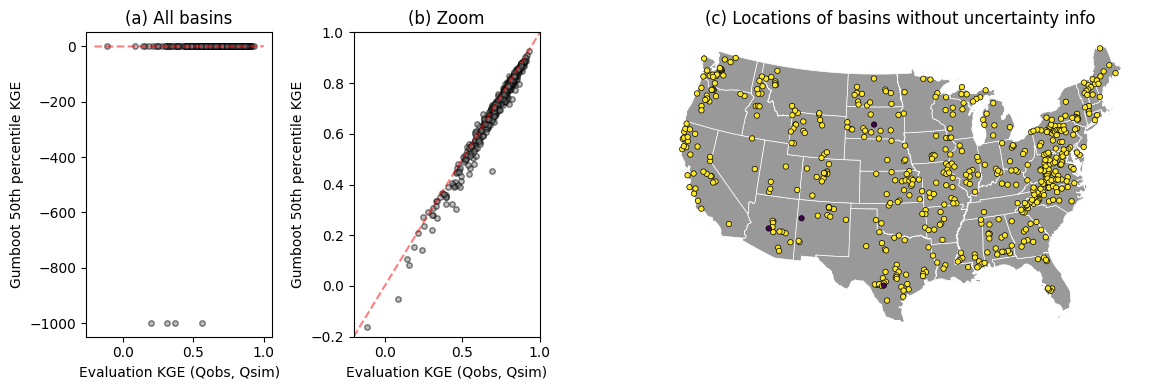

In [19]:
# Compare gumboot KGE with "best" KGE
fig, axs = plt.subplots(1,3,figsize=(12,4),gridspec_kw={'width_ratios': [1, 1, 3]})

ax = axs[0]
ax.scatter(df_sub['best_eval_score'], df_sub['p50'], c='grey', edgecolor='k', alpha=0.5, s=15)
ax.plot([-.2,1],[-.2,1],'--r', alpha=0.5)
ax.set_xlabel('Evaluation KGE (Qobs, Qsim)')
ax.set_ylabel('Gumboot 50th percentile KGE')
ax.set_title('(a) All basins')

ax = axs[1]
ax.scatter(df_sub['best_eval_score'], df_sub['p50'], c='grey', edgecolor='k', alpha=0.5, s=15)
ax.plot([-.2,1],[-.2,1],'--r', alpha=0.5)
ax.set_ylim([-.2,1])
ax.set_xlim([-.2,1])
ax.set_xlabel('Evaluation KGE (Qobs, Qsim)')
ax.set_ylabel('Gumboot 50th percentile KGE')
ax.set_title('(b) Zoom')

ax = axs[2]
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
gdf_sub.plot(ax=ax, column='score', markersize=15, edgecolor='k', linewidth=0.5)
ax.set_title('(c) Locations of basins without uncertainty info')
ax.set_axis_off()

plt.tight_layout()
plt.savefig(img_kge_reg_folder/'gumboot_out.png', dpi=300, bbox_inches='tight')

In [20]:
# Remove those four basins
gdf_gumboot = gdf_sub[gdf_sub['score'] > -990].copy()

In [21]:
# Define the uncertainty range
gdf_gumboot['range_5_95'] = gdf_gumboot['p95']-gdf_gumboot['p05']

#### Uncertainty example
Show two examples (low and high uncertainty) for method section.

In [22]:
# Select two basins
basin1 = gdf_gumboot[gdf_gumboot['range_5_95'] == gdf_gumboot['range_5_95'].max()]
basin2 = gdf_gumboot[gdf_gumboot['range_5_95'] == gdf_gumboot['range_5_95'].min()]

In [23]:
# Cal/val settings from Knoben et al. (2020)
cal_s = '1989-01-01'
cal_e = '1998-12-31'
val_s = '1999-01-01'
val_e = '2009-12-31'

In [24]:
# Prep a custom legend for hydrographs
obs_line = Line2D([0], [0], color='lightgrey', lw=2, label='Simulations (all models)')
sim_line = Line2D([0], [0], color='royalblue', lw=2, label='Observations')

In [25]:
def method_plot_data_prep(basin):

    # - Scores
    # Create plotting data from the selected rows
    models = []
    values = []
    for column in basin.columns:
        if "_val_kge" in column:
            values.append(basin[column].values[0])
            models.append(basin[column].name[0:3])
    values = np.array(values)
    xx = np.arange(0,len(values))
    
    # Find x-coordinate of best model, by matching the model identifiers to the list of models we have
    xb = xx[np.array(models) == basin['best_eval_model'].values[0].replace('_','')]

    # Hydrographs
    qsims = []
    for model in models:
        qsim = get_marrmot_sim_in_mm_d(model_netcdfs, basin.index[0], model.replace('m','m_'), of_index=0)
        qsim.rename(columns={'qsim':model}, inplace=True)
        qsims.append(qsim)
    qsim_plot_df = pd.concat(qsims, axis=1)

    return models,values,xx,xb,qsim_plot_df

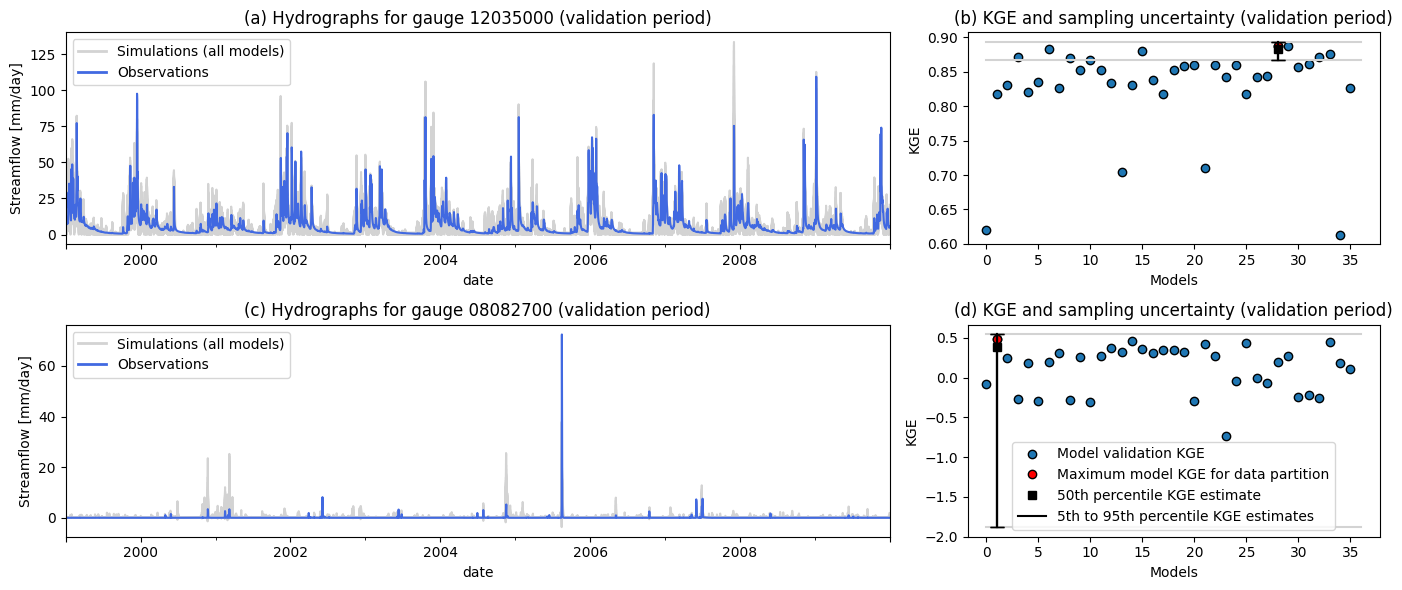

In [26]:
fig,axs = plt.subplots(2,2,figsize=(14,6), width_ratios=[2, 1])

# Basin2 (min uncertainty range)
# ------------------------------
models,values,xx,xb,qsim_plot_df = method_plot_data_prep(basin2)

# Hydrograph 1
ax = axs[0,0]
qsim_plot_df.loc[val_s:val_e].plot(ax=ax, color='lightgrey', legend=False)
qobs_all[basin2.index].loc[val_s:val_e].plot(ax=ax, color='royalblue', legend=False)
ax.set_title(f'(a) Hydrographs for gauge {int(basin2.index[0]):08d} (validation period)')
ax.set_ylabel('Streamflow [mm/day]')
ax.legend(handles=[obs_line, sim_line], loc='upper left') # custom so we don't get 40 grey lines

# Model scores 1
ax = axs[0,1]
ax.plot(xx,values, linestyle='None', marker='o', markeredgecolor='k')
ax.plot(xb,basin2['score'],'r', linestyle='None', marker='o', markeredgecolor='k') # actual score
ax.plot(xb,basin2['p50'],'k', linestyle='None', marker='s') # p50
ax.plot([xb,xb],[basin2['p05'],basin2['p95']],'k') # uncertainty range
ax.plot([0,len(values)],[basin2['p05'],basin2['p05']], color='lightgrey')
ax.plot([0,len(values)],[basin2['p95'],basin2['p95']], color='lightgrey')
ax.errorbar([xb,xb],[basin2['p05'],basin2['p95']], yerr=[[0, 0], [0, 0]], fmt='k', capsize=5) # horizontal caps at either end
ax.set_xlabel('Models')
#ax.set_xticks(xx)
#ax.set_xticklabels(models, rotation=90)
ax.set_ylabel('KGE')
ax.set_title('(b) KGE and sampling uncertainty (validation period)')
plt.legend(['Model validation KGE','Maximum model KGE for data partition','50th percentile KGE estimate','5th to 95th percentile KGE estimates'])

# Basin1 (max uncertainty range)
# ------------------------------
models,values,xx,xb,qsim_plot_df = method_plot_data_prep(basin1)

# Hydrograph 2
ax = axs[1,0]
qsim_plot_df.loc[val_s:val_e].plot(ax=ax, color='lightgrey', legend=False)
qobs_all[basin1.index].loc[val_s:val_e].plot(ax=ax, color='royalblue', legend=False)
ax.set_title(f'(c) Hydrographs for gauge {int(basin1.index[0]):08d} (validation period)')
ax.set_ylabel('Streamflow [mm/day]')
ax.legend(handles=[obs_line, sim_line], loc='upper left') # custom so we don't get 40 grey lines

# Model scores 2
ax = axs[1,1]
ax.plot(xx,values, linestyle='None', marker='o', markeredgecolor='k')
ax.plot(xb,basin1['score'],'r', linestyle='None', marker='o', markeredgecolor='k') # actual score
ax.plot(xb,basin1['p50'],'k', linestyle='None', marker='s') # p50
ax.plot([xb,xb],[basin1['p05'],basin1['p95']],'k') # uncertainty range
ax.plot([0,len(values)],[basin1['p05'],basin1['p05']], color='lightgrey')
ax.plot([0,len(values)],[basin1['p95'],basin1['p95']], color='lightgrey')
ax.errorbar([xb,xb],[basin1['p05'],basin1['p95']], yerr=[[0, 0], [0, 0]], fmt='k', capsize=5) # horizontal caps at either end
ax.set_xlabel('Models')
#ax.set_xticks(xx)
#ax.set_xticklabels(models, rotation=90)
ax.set_ylabel('KGE')
ax.set_title('(d) KGE and sampling uncertainty (validation period)')
plt.legend(['Model validation KGE','Maximum model KGE for data partition','50th percentile KGE estimate','5th to 95th percentile KGE estimates'])

plt.tight_layout()
plt.savefig(img_kge_reg_folder/'methodology.png', dpi=300, bbox_inches='tight')

### Set up a color scheme for the rest of the plots

In [27]:
# Define a colormap for KGE uncertainty where values below 0.1 are red
cmap_unc = plt.get_cmap('viridis')
cmap_unc.set_over('red')
cmap_unc.set_under('purple')

In [28]:
# Define a colormap for all models where colors are discrete
n_classes = len(model_netcdfs)
cmap_all = plt.get_cmap('nipy_spectral', n_classes)

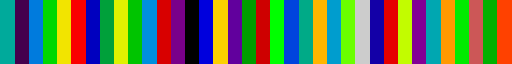

In [29]:
# Re-arrange for increased clarity on various maps
cmap_arr = cmap_all(np.arange(n_classes)) # as array
cmap_all = ListedColormap(
        [
            cmap_arr[13], # m01
            cmap_arr[1 ], # m02
            cmap_arr[9 ], # m03
            cmap_arr[19], # m04
            cmap_arr[25], # m05
            cmap_arr[30], # m06
            cmap_arr[6 ], # m07
            cmap_arr[15], # m08
            cmap_arr[24], # m09
            cmap_arr[18], # m10
            cmap_arr[10], # m11
            cmap_arr[32], # m12
            cmap_arr[2 ], # m13
            cmap_arr[0 ], # m14
            cmap_arr[7 ], # m15
            cmap_arr[26], # m16
            cmap_arr[4 ], # m17
            cmap_arr[16], # m18
            cmap_arr[33], # m19
            cmap_arr[21], # m20
            cmap_arr[8 ], # m21
            cmap_arr[14], # m22
            cmap_arr[27], # m24
            cmap_arr[11], # m25
            cmap_arr[22], # m26
            cmap_arr[35], # m27
            cmap_arr[5 ], # m28
            cmap_arr[31], # m29
            cmap_arr[23], # m30
            cmap_arr[3 ], # m31
            cmap_arr[12], # m32
            cmap_arr[28], # m34
            cmap_arr[20], # m35
            cmap_arr[34], # m36
            cmap_arr[17], # m37
            cmap_arr[29], # m40
        ]
    )
cmap_all

In [30]:
# Create a model-to-color dictionary
color_dict = {model.split('/')[-1][0:4]: cmap_all(i) for i, model in enumerate(model_netcdfs)}

#### Context
Show maximum KGE scores, uncertainty and the scatter in "best" models.

In [31]:
# Define the plotting columns
gdf_gumboot['range_5_95'] = gdf_gumboot['p95']-gdf_gumboot['p05']
gdf_gumboot['best_eval_model_num'] = gdf_gumboot.apply(lambda row: int(row['best_eval_model'][2:4]), axis=1) # possibly not needed

/var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T/ipykernel_66898/2962592364.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


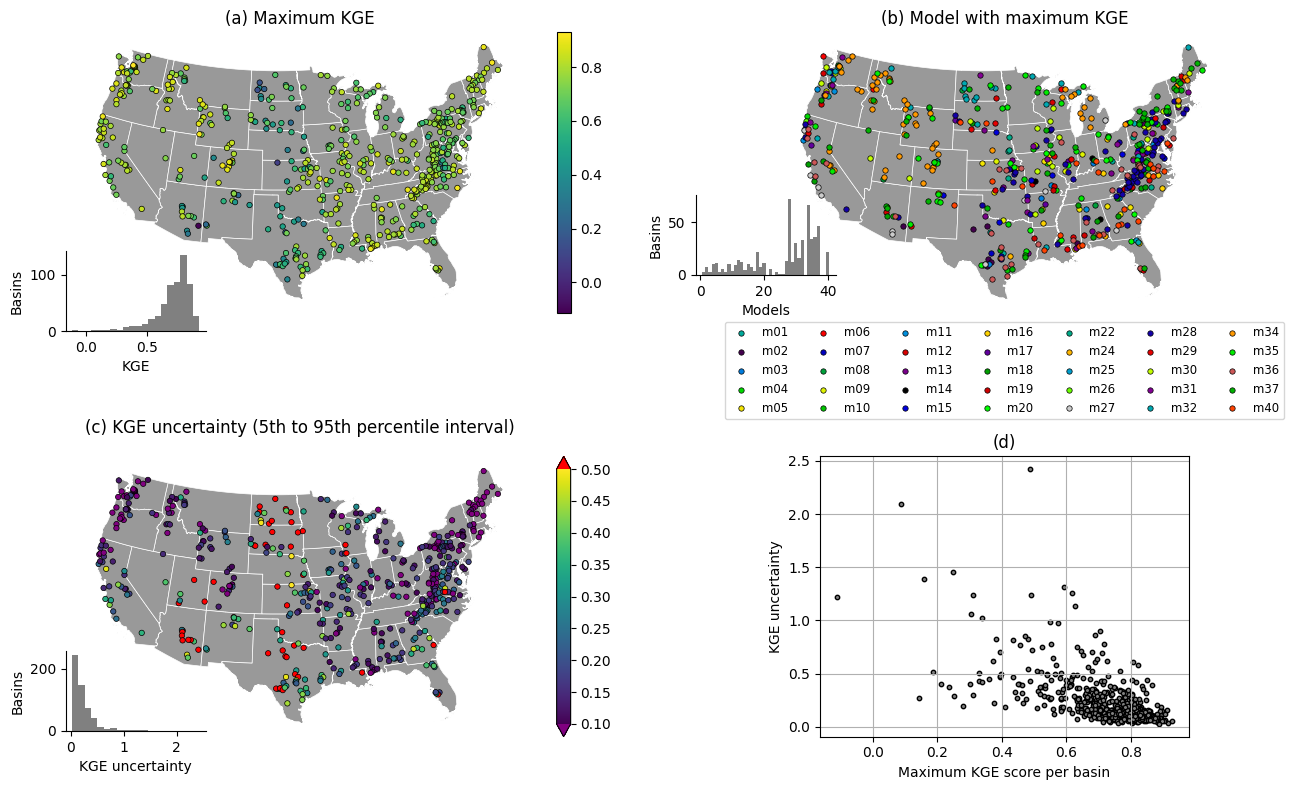

In [32]:
fig,axs = plt.subplot_mosaic([['max_kge', 'best_model'],
                              ['kge_unc', 'scatter']], figsize=(14,8))

# max KGE
ax = axs['max_kge']
ax.set_title('(a) Maximum KGE') # map
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
h = gdf_gumboot.plot(ax=ax, column='score', markersize=15, edgecolor='k', linewidth=0.5, legend=True)
ax.set_axis_off()

hist_ax1 = fig.add_axes([0.06, 0.58, 0.1, 0.1])  # Adding an inset at the bottom right corner
hist_ax1.hist(gdf_gumboot['score'], color='grey', bins=20)
hist_ax1.set_xlabel('KGE')
hist_ax1.set_ylabel('Basins')
hist_ax1.spines['top'].set_visible(False)
hist_ax1.spines['right'].set_visible(False)
hist_ax1.patch.set_facecolor('none')

# Best model
ax = axs['best_model']
ax.set_title('(b) Model with maximum KGE') # map
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)

unique_models = gdf_gumboot['best_eval_model'].unique()
unique_models.sort() # so it plots from m_01 to m_40 in order
for model in unique_models:
    gdf_subset = gdf_gumboot[gdf_gumboot['best_eval_model'] == model]
    gdf_subset.plot(ax=ax, color=color_dict[model], markersize=15, edgecolor='k', linewidth=0.5, label=model.replace('_',''))
ax.legend(ncol=7, loc='lower center',fontsize='small', bbox_to_anchor=(0.5, -0.4))
ax.set_axis_off()

hist_ax2 = fig.add_axes([0.51, 0.65, 0.1, 0.1])  # Adding an inset at the bottom right corner
hist_ax2.hist(gdf_gumboot['best_eval_model_num'], color='grey', bins=np.arange(0.5,41.5,1))
hist_ax2.set_xlabel('Models')
hist_ax2.set_ylabel('Basins')
hist_ax2.spines['top'].set_visible(False)
hist_ax2.spines['right'].set_visible(False)
hist_ax2.patch.set_facecolor('none')

# KGE uncertainty
ax = axs['kge_unc']
ax.set_title('(c) KGE uncertainty (5th to 95th percentile interval)') # map
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
h = gdf_gumboot.plot(ax=ax, column='range_5_95', markersize=15, edgecolor='k', linewidth=0.5, 
                     vmin=0.1, vmax=0.5, cmap=cmap_unc, legend=True, legend_kwds={'extend':'both'})
ax.set_axis_off()

hist_ax3 = fig.add_axes([0.06, 0.08, 0.1, 0.1])  # Adding an inset at the bottom right corner
hist_ax3.hist(gdf_gumboot['range_5_95'], color='grey', bins=20)
hist_ax3.set_xlabel('KGE uncertainty')
hist_ax3.set_ylabel('Basins')
hist_ax3.spines['top'].set_visible(False)
hist_ax3.spines['right'].set_visible(False)
hist_ax3.patch.set_facecolor('none')


# KGE vs uncertainty
ax = axs['scatter']
ax.set_title('(d)') # hist
ax.scatter(gdf_gumboot['best_eval_score'],gdf_gumboot['range_5_95'],
          color='grey', edgecolor='k',s=10, )
ax.set_xlabel('Maximum KGE score per basin')
ax.set_ylabel('KGE uncertainty')
ax.set_aspect(0.33, adjustable='box')
ax.grid()


plt.tight_layout()
plt.savefig(img_kge_reg_folder/'study_context.png', dpi=300, bbox_inches='tight')

#### Research questions
Question 1: For each model, how often does it fall within the uncertainty bounds of the best model?

Question 2: How many models do we have per basin?

We'll define uncertainty bounds here as the 5th to 95th percentile, so we'll count any model with a calculated performance above the 5th percentile as "close enough".

In [36]:
# Check if models outperform the p05 benchmark
models = []
above_p5_counts = []
columns_flags = []
for column_val in columns_val:
    model = column_val.split('_')[0] # 'm01_val_kge' > 'm01'
    flag_column = f'{model}_above_p5'
    gdf_gumboot[flag_column] = gdf_gumboot[column_val] >= gdf_gumboot['p05']
    
    models.append(model)
    above_p5_counts.append(gdf_gumboot[flag_column].sum())
    columns_flags.append(flag_column)

In [37]:
# Count how many models beat the p05 benchmark per basin
gdf_gumboot['similar_model_count'] = gdf_gumboot[columns_flags].sum(axis=1)

In [38]:
# Print the stats we use in the manuscript text
num_basins = len(gdf_gumboot)

min_val = min(above_p5_counts)
min_idx = [i for i, x in enumerate(above_p5_counts) if x == min_val]
print(f'Model {models[min_idx[0]]} occurs least often at {min_val} ({min_val/num_basins*100:.1f}%) cases.')

max_val = max(above_p5_counts)
max_idx = [i for i, x in enumerate(above_p5_counts) if x == max_val]
print(f'Model {models[max_idx[0]]} occurs most often at {max_val} ({max_val/num_basins*100:.1f}%) cases.')

no_count = (gdf_gumboot['similar_model_count'].values == 0).sum()
print(f'No models within uncertainty bounds in {no_count} ({no_count/num_basins*100:.1f}%) cases.')

all_count = (gdf_gumboot['similar_model_count'].values == 36).sum()
print(f'All models within uncertainty bounds in {all_count} ({all_count/num_basins*100:.1f}%) cases.')

Model m01 occurs least often at 53 (9.5%) cases.
Model m28 occurs most often at 362 (65.2%) cases.
No models within uncertainty bounds in 0 (0.0%) cases.
All models within uncertainty bounds in 7 (1.3%) cases.


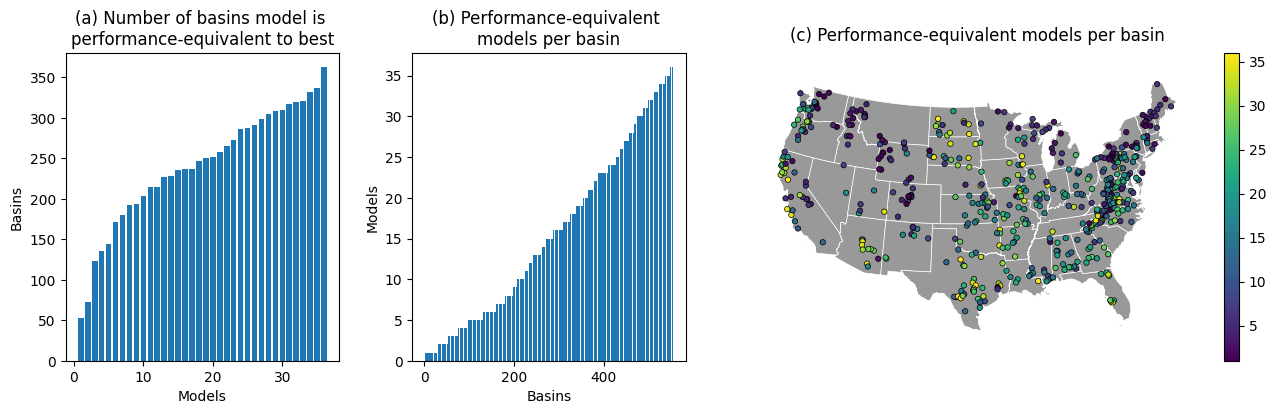

In [39]:
fig, axs = plt.subplots(1,3,figsize=(16,4),gridspec_kw={'width_ratios': [1, 1, 2]})

ax = axs[0]
ax.set_title('(a) Number of basins model is \nperformance-equivalent to best') # Model KGE > gumboot p05 estimate for best model
ax.bar(range(1,len(above_p5_counts)+1), sorted(above_p5_counts))
ax.set_xlabel('Models')
ax.set_ylabel('Basins')

ax = axs[1]
ax.set_title('(b) Performance-equivalent \nmodels per basin') # Model KGE > gumboot p05 estimate for best model
ax.bar(range(1,len(gdf_gumboot['similar_model_count'])+1), sorted(gdf_gumboot['similar_model_count'].values))
ax.set_xlabel('Basins')
ax.set_ylabel('Models')

ax = axs[2]
ax.set_title('(c) Performance-equivalent models per basin\n') # map
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
gdf_gumboot.plot(ax=ax, column='similar_model_count', markersize=15, edgecolor='k', linewidth=0.5, legend=True)
ax.set_axis_off()

plt.savefig(img_kge_reg_folder/'good_model_counts.png', dpi=300, bbox_inches='tight')

Question 3: How many models do we need to model all basins?

In [557]:
# Greedy model selection to fill gaps
# Replaced by linear programming, but keeping for posterity
'''
tmp_df = gdf_gumboot.copy()
models_needed = []
basins_filled = []

basins_left = len(df)
while basins_left > 0:

    # Perform a greedy selection for the basins we have left
    models_needed.append(tmp_df[columns_flags].sum().idxmax())
    basins_filled.append(tmp_df[models_needed[-1]].sum())

    # Subset the dataframe to keep only those basins for which we have no model yet
    if models_needed: # False if models_needed is empty
        tmp_df = tmp_df[~tmp_df[models_needed[-1]]] # Remove any basins for which the latest added model works
    basins_left = len(tmp_df) # Update the count of basins we still need - this will terminate the loop

# Print results
cumsum_fill = np.array(basins_filled).cumsum()/555
print("Model selection overview:")
for model,basins,total in zip(models_needed, basins_filled,cumsum_fill):
    print(f"Model {model[0:3]} used in {basins:3d} basins ({total*100:4.1f}%)")
''';

In [40]:
# --- Set up the LP problem
# Define the universal set (all basins)
all_basins = set(gdf_gumboot.index.unique()) 

# Define the subsets (i.e., list of basins where model X val KGE > gumboot p5 estimated KGE)
subsets = []
above_p5_columns = [column for column in gdf_gumboot.columns if "_above_p5" in column]
models = []
for column in above_p5_columns:
    basins = []
    small_df = gdf_gumboot[[column]]
    models.append(column.split('_')[0])
    for ix,row in small_df.iterrows():
        if row[column]: # i.e., model KGE above p05 KGE estimate in this basin
            basins.append(row.name)
    subsets.append(set(basins))

In [41]:
# Solve the LP problem
num_selected, selected_indices, selected_subsets = min_set_cover(all_basins, subsets)
selected_models = [models[ix] for ix in selected_indices]
covered_basins = [len(ss) for ss in selected_subsets]
print("Number of subsets selected:", num_selected)
print("Indices of selected subsets:", selected_indices)
print("Selected models:", selected_models)
print("Basins covered:", covered_basins)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wmk934/code/multi_model_mosaic/mmm_python_r_venv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T/22d4b783dcae40879c5150f62eb1224d-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T/22d4b783dcae40879c5150f62eb1224d-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 560 COLUMNS
At line 9342 RHS
At line 9898 BOUNDS
At line 9935 ENDATA
Problem MODEL has 555 rows, 36 columns and 8673 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 10 - 0.00 seconds
Cgl0004I processed model has 19 rows, 27 columns (27 integer (27 of which binary)) and 121 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution fou

In [42]:
# Prep LP outputs for plotting
models_needed,basins_filled = sort_selected_subsets_by_coverage(all_basins, selected_subsets, selected_models, match_output_to_existing=True)

In [44]:
# Print the number of basins covered by each next model
basins_filled

[np.int64(362),
 np.int64(114),
 np.int64(36),
 np.int64(22),
 np.int64(8),
 np.int64(5),
 np.int64(4),
 np.int64(2),
 np.int64(1),
 np.int64(1)]

/var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T/ipykernel_90274/3270907672.py:24: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  gdf_plot = gpd.GeoDataFrame(pd.concat([gdf_plot,new_gdf])) # Append to what we already have


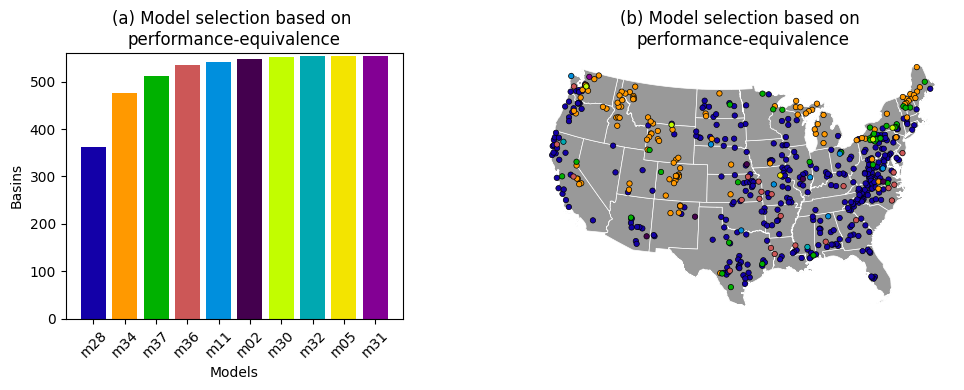

In [42]:
# Define the model names in a way that maps onto our color dictionary
model_names = [f"{model[0]}_{model[1:3]:02}" for model in models_needed]

# Empty dataframe to start with: this avoids clunky if ix==0: else: constructions
gdf_plot = gpd.GeoDataFrame(columns=['gauge_id','geometry'])
gdf_plot.set_index('gauge_id', inplace=True)

# Empty xticklabels
xticklabels = [""] * len(models_needed)

# Loop over the models we identified and create incremental plots
for ix,model in enumerate(models_needed):

    # Define bar plotting stats
    bar_x = range(1,len(models_needed)+1) # always the same but kept here for clarity
    bar_y = np.cumsum(basins_filled[0:(ix+1)])
    bar_y = np.pad(bar_y, (0, len(bar_x)-len(bar_y)), mode='constant')
    
    # Define map plotting stats
    add_these = [index for index in gdf_gumboot[models_needed[ix]].index if (index not in gdf_plot.index) and gdf_gumboot[models_needed[ix]][index]] # Checks which NEW
            # basins we need to add at this step of the loop
    new_gdf = gpd.GeoDataFrame(geometry=gdf_gumboot.loc[add_these]['geometry']) # Get the locations. This also has the basin ID as the dataframe index
    new_gdf['color'] = [color_dict[model_names[ix]]] * len(new_gdf)
    gdf_plot = gpd.GeoDataFrame(pd.concat([gdf_plot,new_gdf])) # Append to what we already have

    # Add the model abbreviation to the xtick labels
    xticklabels[ix] = models_needed[ix][0:3]
    
    # Make the actual figure  
    fig, axs = plt.subplots(1,2,figsize=(11,4),gridspec_kw={'width_ratios': [1, 2]})
    
    # bar plot
    ax = axs[0]
    ax.set_title('(a) Model selection based on \nperformance-equivalence') # Model KGE > gumboot p05 estimate for best model
    ax.bar(bar_x, bar_y, color=[color_dict[name] for name in model_names])  
    ax.set_xlabel('Models')
    ax.set_xticks(range(1,len(models_needed)+1))
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.set_ylabel('Basins')
    ax.set_ylim([0,560])
    
    # map
    ax = axs[1]
    ax.set_title('(b) Model selection based on \nperformance-equivalence') # map
    conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
    gdf_plot.plot(ax=ax, color=gdf_plot['color'], markersize=15, edgecolor='k', linewidth=0.5, legend=True)
    ax.set_axis_off()
    
    plt.tight_layout()

    filename = f'marrmot_models_needed_for_camels_{ix:02}.png'
    plt.savefig(img_kge_reg_folder/filename, dpi=300, bbox_inches='tight')
    if ix < len(models_needed)-1:
        plt.close() # keeps the last plot open so we can see what we did

### KGE(1/Q): reduced analysis

##### Data loading

In [46]:
# Get the KGE(1/Q) results
of_index = 1 # 0 for KGE(1/Q)
df_sub = pd.read_csv(csv_folder/csv_gumboot_name.format(of_index), index_col=0)

In [47]:
# We'll move everything into a GeoDataFrame for easier plotting with the state boundaries
geometry = [Point(lon, lat) for lon, lat in zip(df_sub['gauge_lon'], df_sub['gauge_lat'])] # Create a geometry column representing Point objects with lat/lon coordinates
gdf_sub = gpd.GeoDataFrame(df_sub, geometry=geometry, crs='EPSG:4326')
gdf_sub = gdf_sub.to_crs(conus.crs)

In [48]:
# The modification of Qobs and Qsim by adding a small value e, should have prevented issues with no flow calculations
# Confirm that we have gumboot outputs for all basins
# Remove those four basins
print(f"{(gdf_sub['score'] < -990).sum()} basins with -999 gumboot scores")
gdf_gumboot = gdf_sub.copy() # so we can re-use some existing code

0 basins with -999 gumboot scores


#### Quick check of comparibility of full-period KGE and 50th percentile KGE estimate (not for paper)

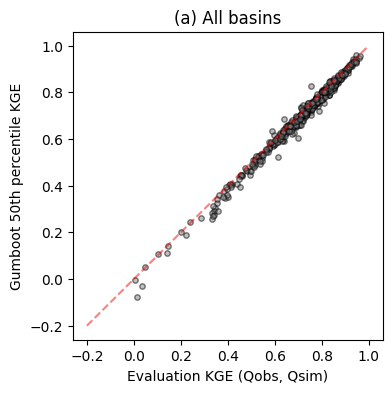

In [68]:
# Compare gumboot KGE with "best" KGE
fig, ax = plt.subplots(1,1,figsize=(4,4))
ax.scatter(df_sub['best_eval_score'], df_sub['p50'], c='grey', edgecolor='k', alpha=0.5, s=15)
ax.plot([-.2,1],[-.2,1],'--r', alpha=0.5)
ax.set_xlabel('Evaluation KGE (Qobs, Qsim)')
ax.set_ylabel('Gumboot 50th percentile KGE')
ax.set_title('(a) All basins');

##### KGE and uncertainty plot (not for paper)

In [49]:
# Define the plotting columns
gdf_gumboot['range_5_95'] = gdf_gumboot['p95']-gdf_gumboot['p05']
gdf_gumboot['best_eval_model_num'] = gdf_gumboot.apply(lambda row: int(row['best_eval_model'][2:4]), axis=1) # possibly not needed

/var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T/ipykernel_66898/2382242761.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


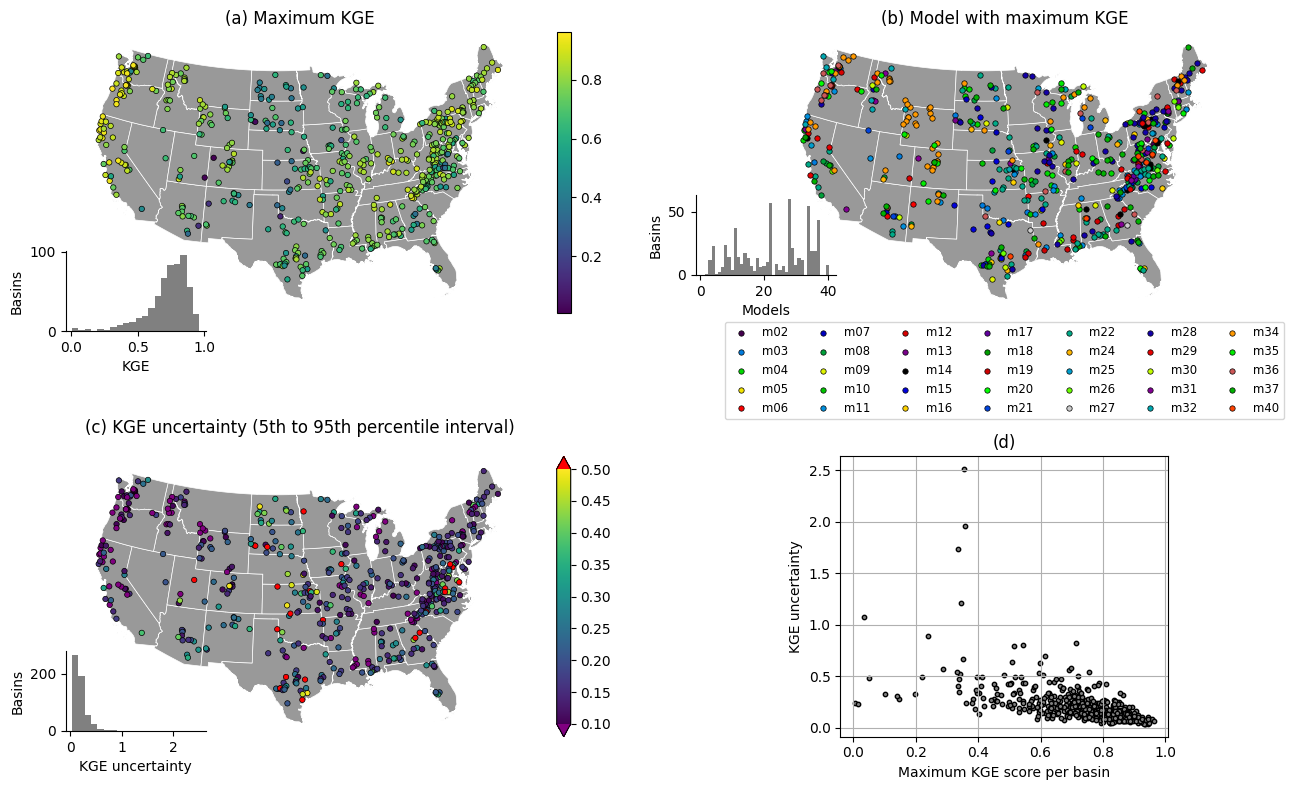

In [50]:
fig,axs = plt.subplot_mosaic([['max_kge', 'best_model'],
                              ['kge_unc', 'scatter']], figsize=(14,8))

# max KGE
ax = axs['max_kge']
ax.set_title('(a) Maximum KGE') # map
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
h = gdf_gumboot.plot(ax=ax, column='score', markersize=15, edgecolor='k', linewidth=0.5, legend=True)
ax.set_axis_off()

hist_ax1 = fig.add_axes([0.06, 0.58, 0.1, 0.1])  # Adding an inset at the bottom right corner
hist_ax1.hist(gdf_gumboot['score'], color='grey', bins=20)
hist_ax1.set_xlabel('KGE')
hist_ax1.set_ylabel('Basins')
hist_ax1.spines['top'].set_visible(False)
hist_ax1.spines['right'].set_visible(False)
hist_ax1.patch.set_facecolor('none')

# Best model
ax = axs['best_model']
ax.set_title('(b) Model with maximum KGE') # map
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
unique_models = gdf_gumboot['best_eval_model'].unique()
unique_models.sort() # so it plots from m_01 to m_40 in order
for model in unique_models:
    gdf_subset = gdf_gumboot[gdf_gumboot['best_eval_model'] == model]
    gdf_subset.plot(ax=ax, color=color_dict[model], markersize=15, edgecolor='k', linewidth=0.5, label=model.replace('_',''))
ax.legend(ncol=7, loc='lower center',fontsize='small', bbox_to_anchor=(0.5, -0.4))
ax.set_axis_off()

hist_ax2 = fig.add_axes([0.51, 0.65, 0.1, 0.1])  # Adding an inset at the bottom right corner
hist_ax2.hist(gdf_gumboot['best_eval_model_num'], color='grey', bins=np.arange(0.5,41.5,1))
hist_ax2.set_xlabel('Models')
hist_ax2.set_ylabel('Basins')
hist_ax2.spines['top'].set_visible(False)
hist_ax2.spines['right'].set_visible(False)
hist_ax2.patch.set_facecolor('none')

# KGE uncertainty
ax = axs['kge_unc']
ax.set_title('(c) KGE uncertainty (5th to 95th percentile interval)') # map
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
h = gdf_gumboot.plot(ax=ax, column='range_5_95', markersize=15, edgecolor='k', linewidth=0.5, 
                     vmin=0.1, vmax=0.5, cmap=cmap_unc, legend=True, legend_kwds={'extend':'both'})
ax.set_axis_off()

hist_ax3 = fig.add_axes([0.06, 0.08, 0.1, 0.1])  # Adding an inset at the bottom right corner
hist_ax3.hist(gdf_gumboot['range_5_95'], color='grey', bins=20)
hist_ax3.set_xlabel('KGE uncertainty')
hist_ax3.set_ylabel('Basins')
hist_ax3.spines['top'].set_visible(False)
hist_ax3.spines['right'].set_visible(False)
hist_ax3.patch.set_facecolor('none')


# KGE vs uncertainty
ax = axs['scatter']
ax.set_title('(d)') # hist
ax.scatter(gdf_gumboot['best_eval_score'],gdf_gumboot['range_5_95'],
          color='grey', edgecolor='k',s=10, )
ax.set_xlabel('Maximum KGE score per basin')
ax.set_ylabel('KGE uncertainty')
ax.set_aspect(0.33, adjustable='box')
ax.grid()


plt.tight_layout()
plt.savefig(img_kge_low_folder/'study_context.png', dpi=300, bbox_inches='tight')

##### Combined plot of model counts, basin counts and number of models needed for 100% coverage

In [51]:
# Check if models outperform the p05 benchmark
models = []
above_p5_counts = []
columns_flags = []
for column_val in columns_val:
    model = column_val.split('_')[0] # 'm01_val_kge' > 'm01'
    flag_column = f'{model}_above_p5'
    gdf_gumboot[flag_column] = gdf_gumboot[column_val] >= gdf_gumboot['p05']
    
    models.append(model)
    above_p5_counts.append(gdf_gumboot[flag_column].sum())
    columns_flags.append(flag_column)

In [52]:
# Count how many models beat the p05 benchmark per basin
gdf_gumboot['similar_model_count'] = gdf_gumboot[columns_flags].sum(axis=1)

In [53]:
# Repeat the stats we used before for KGE(1/Q)
num_basins = len(gdf_gumboot)

min_val = min(above_p5_counts)
min_idx = [i for i, x in enumerate(above_p5_counts) if x == min_val]
print(f'Model {models[min_idx[0]]} occurs least often at {min_val} ({min_val/num_basins*100:.1f}%) cases.')

max_val = max(above_p5_counts)
max_idx = [i for i, x in enumerate(above_p5_counts) if x == max_val]
print(f'Model {models[max_idx[0]]} occurs most often at {max_val} ({max_val/num_basins*100:.1f}%) cases.')

no_count = (gdf_gumboot['similar_model_count'].values == 0).sum()
print(f'No models within uncertainty bounds in {no_count} ({all_count/num_basins*100:.1f}%) cases.')

all_count = (gdf_gumboot['similar_model_count'].values == 36).sum()
print(f'All models within uncertainty bounds in {all_count} ({all_count/num_basins*100:.1f}%) cases.')

Model m01 occurs least often at 1 (0.2%) cases.
Model m28 occurs most often at 263 (47.0%) cases.
No models within uncertainty bounds in 1 (1.3%) cases.
All models within uncertainty bounds in 0 (0.0%) cases.


In [54]:
# Revert to selecting the best model for the case where we have no model above p05
no_model_mask = gdf_gumboot['similar_model_count'] == 0
for basin,entry in no_model_mask.items():
    if entry:
        # Find the best model we have in this case
        bm = gdf_gumboot.loc[basin, 'best_eval_model']
        # Tag this as an "above_p5" case even though this is not technically true - this is the way to make the selecting algorithm below work
        bm = bm.replace('_','') # m_34 > m34
        column_name = f"{bm}_above_p5"
        gdf_gumboot.loc[basin,column_name] = True

In [77]:
# Greedy model selection to fill gaps
# Replaced with LP - keeping for posterity
'''
tmp_df = gdf_gumboot.copy()
models_needed = []
basins_filled = []

basins_left = len(tmp_df)
while basins_left > 0:

    # Perform a greedy selection for the basins we have left
    models_needed.append(tmp_df[columns_flags].sum().idxmax())
    basins_filled.append(tmp_df[models_needed[-1]].sum())

    # Subset the dataframe to keep only those basins for which we have no model yet
    if models_needed: # False if models_needed is empty
        tmp_df = tmp_df[~tmp_df[models_needed[-1]]] # Remove any basins for which the latest added model works
    basins_left = len(tmp_df) # Update the count of basins we still need - this will terminate the loop       

# Print results
cumsum_fill = np.array(basins_filled).cumsum()/num_basins
print("Model selection overview:")
for model,basins,total in zip(models_needed, basins_filled, cumsum_fill):
    print(f"Model {model[0:3]} used in {basins:3d} basins ({total*100:4.1f}%)")
''';

In [55]:
# --- Set up the LP problem
# Define the universal set (all basins)
all_basins = set(gdf_gumboot.index.unique()) 

# Define the subsets (i.e., list of basins where model X val KGE > gumboot p5 estimated KGE)
subsets = []
above_p5_columns = [column for column in gdf_gumboot.columns if "_above_p5" in column]
models = []
for column in above_p5_columns:
    basins = []
    small_df = gdf_gumboot[[column]]
    models.append(column.split('_')[0])
    for ix,row in small_df.iterrows():
        if row[column]: # i.e., model KGE above p05 KGE estimate in this basin
            basins.append(row.name)
    subsets.append(set(basins))

# Solve the LP problem
num_selected, selected_indices, selected_subsets = min_set_cover(all_basins, subsets)
selected_models = [models[ix] for ix in selected_indices]
covered_basins = [len(ss) for ss in selected_subsets]
print("Number of subsets selected:", num_selected)
print("Indices of selected subsets:", selected_indices)
print("Selected models:", selected_models)
print("Basins covered:", covered_basins)

# Prep LP outputs for plotting
models_needed,basins_filled = sort_selected_subsets_by_coverage(all_basins, selected_subsets, selected_models, match_output_to_existing=True)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wmk934/code/multi_model_mosaic/mmm_python_r_venv/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T/aded54c2d2c74c669419d7d92405c971-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T/aded54c2d2c74c669419d7d92405c971-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 564 COLUMNS
At line 5194 RHS
At line 5754 BOUNDS
At line 5791 ENDATA
Problem MODEL has 559 rows, 36 columns and 4521 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 19 - 0.00 seconds
Cgl0004I processed model has 3 rows, 5 columns (5 integer (4 of which binary)) and 7 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of 

In [63]:
for ix,(added,total,perc) in enumerate(zip(basins_filled,np.cumsum(basins_filled),np.cumsum(basins_filled)/559*100)):
    print(f"{ix+1:02}. Added: {added:003}; total {total:003}; percent: {perc:.2f}")

01. Added: 263; total 263; percent: 47.05
02. Added: 113; total 376; percent: 67.26
03. Added: 080; total 456; percent: 81.57
04. Added: 031; total 487; percent: 87.12
05. Added: 018; total 505; percent: 90.34
06. Added: 011; total 516; percent: 92.31
07. Added: 010; total 526; percent: 94.10
08. Added: 007; total 533; percent: 95.35
09. Added: 005; total 538; percent: 96.24
10. Added: 004; total 542; percent: 96.96
11. Added: 004; total 546; percent: 97.67
12. Added: 003; total 549; percent: 98.21
13. Added: 002; total 551; percent: 98.57
14. Added: 002; total 553; percent: 98.93
15. Added: 002; total 555; percent: 99.28
16. Added: 001; total 556; percent: 99.46
17. Added: 001; total 557; percent: 99.64
18. Added: 001; total 558; percent: 99.82
19. Added: 001; total 559; percent: 100.00


/var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T/ipykernel_90274/948989316.py:83: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  gdf_plot = gpd.GeoDataFrame(pd.concat([gdf_plot,new_gdf])) # Append to what we already have
/var/folders/w4/hh0hkdr92cg8llf8s0l5rzj80000gq/T/ipykernel_90274/948989316.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


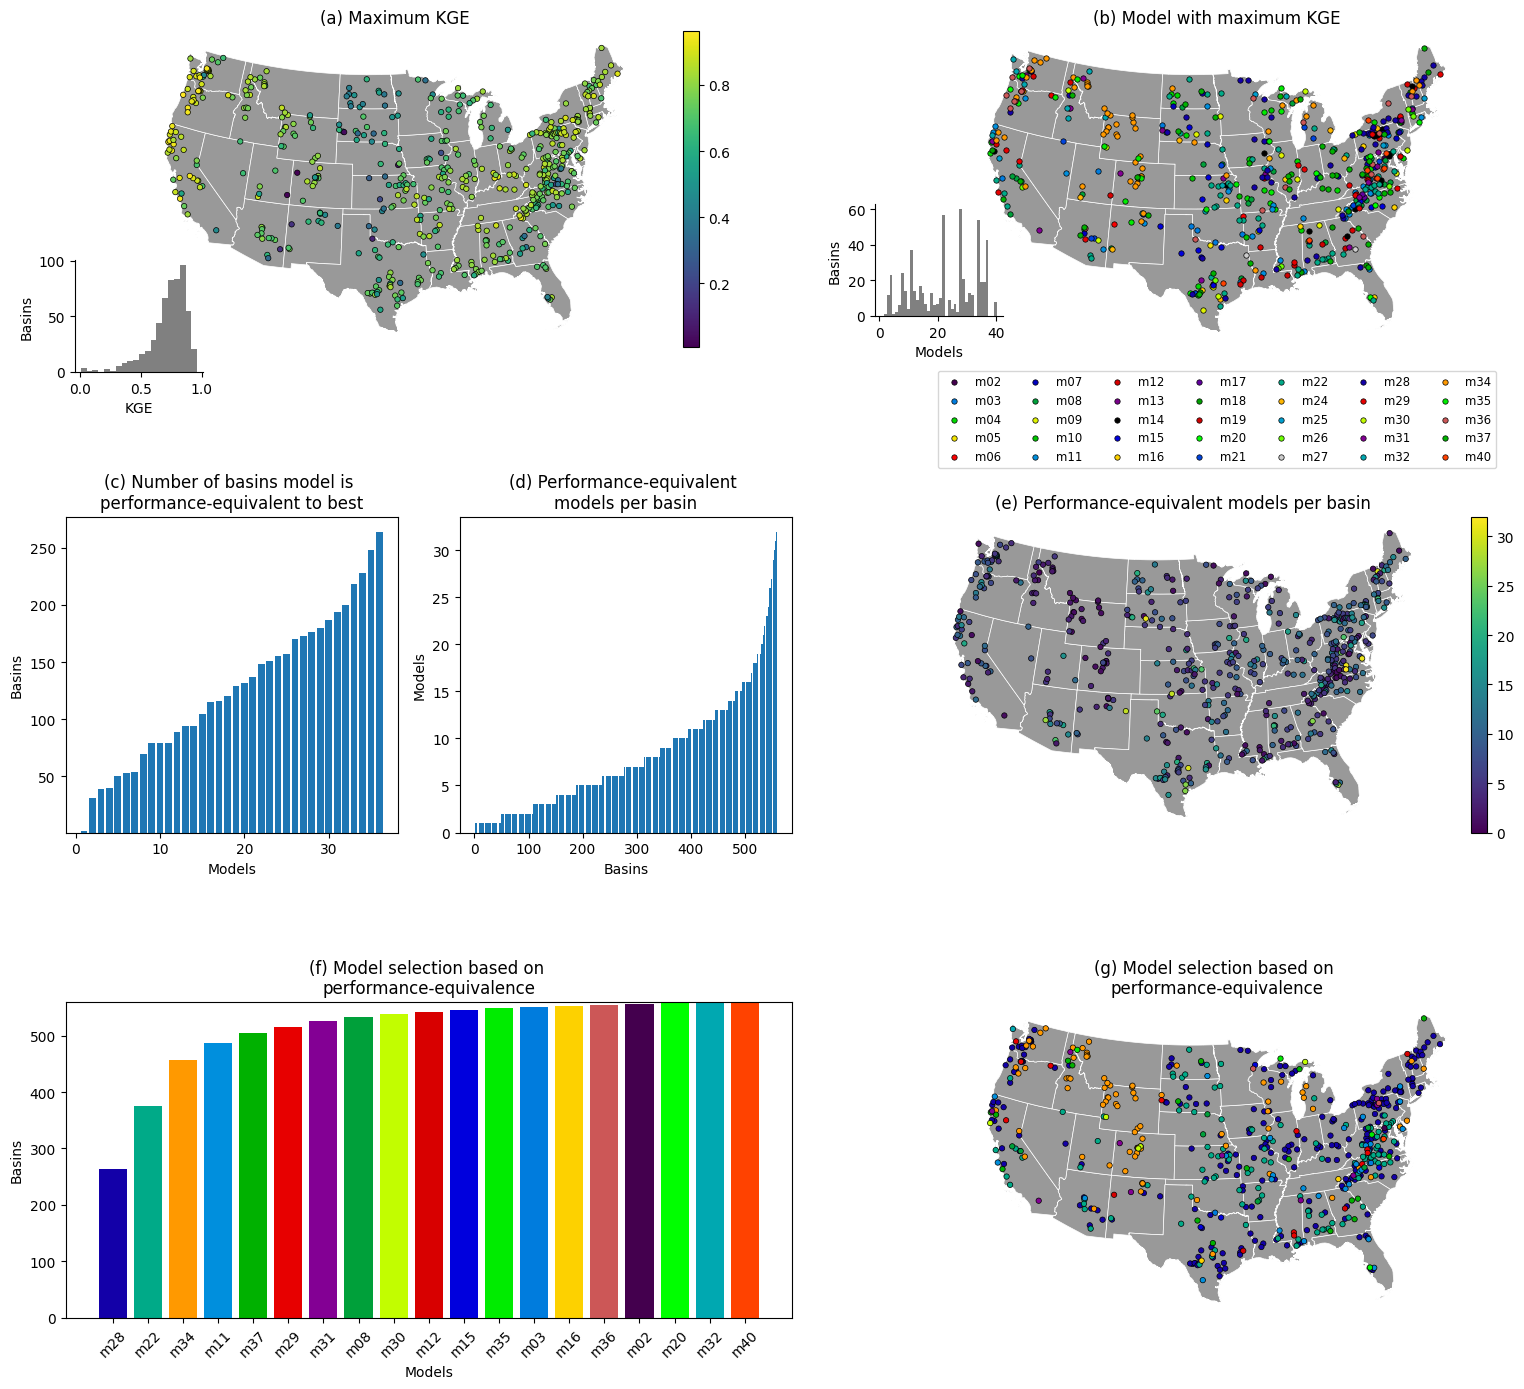

In [54]:
fig, axs = plt.subplot_mosaic("AABB;CDEE;FFGG",figsize=(16,14))

# --- Context (max KGE and model selection)
# max KGE
ax = axs['A']
ax.set_title('(a) Maximum KGE') # map
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
h = gdf_gumboot.plot(ax=ax, column='score', markersize=15, edgecolor='k', linewidth=0.5, legend=True)
ax.set_axis_off()

hist_ax1 = fig.add_axes([0.05, 0.73, 0.08, 0.08])  # Adding an inset at the bottom right corner
hist_ax1.hist(gdf_gumboot['score'], color='grey', bins=20)
hist_ax1.set_xlabel('KGE')
hist_ax1.set_ylabel('Basins')
hist_ax1.spines['top'].set_visible(False)
hist_ax1.spines['right'].set_visible(False)
hist_ax1.patch.set_facecolor('none')

# Best model
ax = axs['B']
ax.set_title('(b) Model with maximum KGE') # map
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
unique_models = gdf_gumboot['best_eval_model'].unique()
unique_models.sort() # so it plots from m_01 to m_40 in order
for model in unique_models:
    gdf_subset = gdf_gumboot[gdf_gumboot['best_eval_model'] == model]
    gdf_subset.plot(ax=ax, color=color_dict[model], markersize=15, edgecolor='k', linewidth=0.5, label=model.replace('_',''))
ax.legend(ncol=7, loc='lower center',fontsize='small', bbox_to_anchor=(0.5, -0.4))
ax.set_axis_off()

hist_ax2 = fig.add_axes([0.55, 0.77, 0.08, 0.08])  # Adding an inset at the bottom right corner
hist_ax2.hist(gdf_gumboot['best_eval_model_num'], color='grey', bins=np.arange(0.5,41.5,1))
hist_ax2.set_xlabel('Models')
hist_ax2.set_ylabel('Basins')
hist_ax2.spines['top'].set_visible(False)
hist_ax2.spines['right'].set_visible(False)
hist_ax2.patch.set_facecolor('none')

# --- Counts
ax = axs['C']
ax.set_title('(c) Number of basins model is \nperformance-equivalent to best') # Model KGE > gumboot p05 estimate for best model
ax.bar(range(1,len(above_p5_counts)+1), sorted(above_p5_counts), bottom=1) # Starts x-axis at 1
ax.set_xlabel('Models')
ax.set_ylabel('Basins')

ax = axs['D']
ax.set_title('(d) Performance-equivalent \nmodels per basin') # Model KGE > gumboot p05 estimate for best model
ax.bar(range(1,len(gdf_gumboot['similar_model_count'])+1), sorted(gdf_gumboot['similar_model_count'].values))
ax.set_xlabel('Basins')
ax.set_ylabel('Models')

ax = axs['E']
ax.set_title('\n(e) Performance-equivalent models per basin') # map
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
gdf_gumboot.plot(ax=ax, column='similar_model_count', markersize=15, edgecolor='k', linewidth=0.5, legend=True)
ax.set_axis_off()


# --- Models needed
# Define the model names in a way that maps onto our color dictionary
model_names = [f"{model[0]}_{model[1:3]:02}" for model in models_needed]

# Empty dataframe to start with: this avoids clunky if ix==0: else: constructions
gdf_plot = gpd.GeoDataFrame(columns=['gauge_id','geometry'])
gdf_plot.set_index('gauge_id', inplace=True)

# Empty xticklabels
xticklabels = [""] * len(models_needed)

# Loop over the models we identified and create incremental plots
for ix,model in enumerate(models_needed):

    # Define bar plotting stats
    bar_x = range(1,len(models_needed)+1) # always the same but kept here for clarity
    bar_y = np.cumsum(basins_filled[0:(ix+1)])
    bar_y = np.pad(bar_y, (0, len(bar_x)-len(bar_y)), mode='constant')
    
    # Define map plotting stats
    add_these = [index for index in gdf_gumboot[models_needed[ix]].index if (index not in gdf_plot.index) and gdf_gumboot[models_needed[ix]][index]] # Checks which NEW
            # basins we need to add at this step of the loop
    new_gdf = gpd.GeoDataFrame(geometry=gdf_gumboot.loc[add_these]['geometry']) # Get the locations. This also has the basin ID as the dataframe index
    new_gdf['color'] = [color_dict[model_names[ix]]] * len(new_gdf)
    gdf_plot = gpd.GeoDataFrame(pd.concat([gdf_plot,new_gdf])) # Append to what we already have

    # Add the model abbreviation to the xtick labels
    xticklabels[ix] = models_needed[ix][0:3]

# bar plot
ax = axs['F']
ax.set_title('(f) Model selection based on \nperformance-equivalence') # Model KGE > gumboot p05 estimate for best model
#ax.bar(bar_x, bar_y, color=colors)
ax.bar(bar_x, bar_y, color=[color_dict[name] for name in model_names])
ax.set_xlabel('Models')
ax.set_xticks(range(1,len(models_needed)+1))
ax.set_xticklabels(xticklabels, rotation=45)
ax.set_ylabel('Basins')
ax.set_ylim([0,560])

# map
ax = axs['G']
ax.set_title('(g) Model selection based on \nperformance-equivalence') # map
conus.plot(ax=ax, color='.6', edgecolor='w', linewidth=0.5)
gdf_plot.plot(ax=ax, color=gdf_plot['color'], markersize=15, edgecolor='k', linewidth=0.5, legend=True)
ax.set_axis_off()
    
plt.tight_layout()

# Save
filename = f'combined_low_flow_plots_{ix:02}.png'
plt.savefig(img_kge_low_folder/filename, dpi=300, bbox_inches='tight')

### Analysis not shown in paper
This is to check if the greedy algorithm we initially used for selection gets us clsoe to the right number of models. To check, I ran a brute force trial of all possible combinations of models to check if there are different combinations that get us to all basins being modelled with fewer than 10 models (KGE(Q) case) being used. This turned out to _NOT_ be the case: the greedy algorithm returns an optimal solution in this case.

The main difference is that the greedy selection algorithm runs in a fracion of a second, and the brute force method takes about half a day.

In [412]:
import time
from itertools import combinations

In [413]:
# Load and prep the data - this repeats a bunch of the things above
df_sub = pd.read_csv(csv_folder/csv_gumboot_name.format(0)) # Results for KGE(Q)

# We'll move everything into a GeoDataFrame for easier plotting with the state boundaries
geometry = [Point(lon, lat) for lon, lat in zip(df_sub['gauge_lon'], df_sub['gauge_lat'])] # Create a geometry column representing Point objects with lat/lon coordinates
gdf_sub = gpd.GeoDataFrame(df_sub, geometry=geometry, crs='EPSG:4326')

# Remove the four basins we have no gumboot results for
gdf_gumboot = gdf_sub[gdf_sub['score'] > -990].copy()

# Column names
columns_val = ['m01_val_kge', 'm02_val_kge', 'm03_val_kge', 'm04_val_kge', 'm05_val_kge', 'm06_val_kge', 'm07_val_kge', 'm08_val_kge', 'm09_val_kge', 
               'm10_val_kge', 'm11_val_kge', 'm12_val_kge', 'm13_val_kge', 'm14_val_kge', 'm15_val_kge', 'm16_val_kge', 'm17_val_kge', 'm18_val_kge',
               'm19_val_kge', 'm20_val_kge', 'm21_val_kge', 'm22_val_kge', 'm24_val_kge', 'm25_val_kge', 'm26_val_kge', 'm27_val_kge', 'm28_val_kge', 
               'm29_val_kge', 'm30_val_kge', 'm31_val_kge', 'm32_val_kge', 'm34_val_kge', 'm35_val_kge', 'm36_val_kge', 'm37_val_kge', 'm40_val_kge']

# Check if models outperform the p05 benchmark
models = []
above_p5_counts = []
columns_flags = []
for column_val in columns_val:
    model = column_val.split('_')[0] # 'm01_val_kge' > 'm01'
    flag_column = f'{model}_above_p5'
    gdf_gumboot[flag_column] = gdf_gumboot[column_val] >= gdf_gumboot['p05']
    
    models.append(model)
    above_p5_counts.append(gdf_gumboot[flag_column].sum())
    columns_flags.append(flag_column)

##### Optimized selection: can we do better than greedy selection?

In [63]:
# we'll just brute force the thing because the number of columns isn't _that_ high
# though this still takes a considerable amount of time to run.
tmp_gdf = gdf_gumboot[columns_flags].copy()
stop = False
start = time.time()
for i in range(2,len(tmp_gdf.columns)):
    mid = time.time()
    print(f'- Checking combinations of size {i: 2d} at {(mid-start)/60:.1f} minutes since starting analysis.')
    for combo in combinations(tmp_gdf.columns, i):
        if tmp_gdf[list(combo)].any(axis=1).sum() == 555:
            print(f'columns {combo} cover all basins')
            stop = True
            break
    if stop:
        end = time.time()
        break

print(f'\n- Found a solution after {(end-start)/60:.1f} minutes since starting analysis.')

- Checking combinations of size  2 at 0.0 minutes since starting analysis.
- Checking combinations of size  3 at 0.0 minutes since starting analysis.
- Checking combinations of size  4 at 0.0 minutes since starting analysis.
- Checking combinations of size  5 at 0.2 minutes since starting analysis.
- Checking combinations of size  6 at 1.3 minutes since starting analysis.
- Checking combinations of size  7 at 7.0 minutes since starting analysis.
- Checking combinations of size  8 at 31.4 minutes since starting analysis.
- Checking combinations of size  9 at 119.5 minutes since starting analysis.
- Checking combinations of size  10 at 390.0 minutes since starting analysis.
columns ('m02_above_p5', 'm05_above_p5', 'm11_above_p5', 'm28_above_p5', 'm30_above_p5', 'm31_above_p5', 'm32_above_p5', 'm34_above_p5', 'm36_above_p5', 'm37_above_p5') cover all basins

- Found a solution after 682.6 minutes since starting analysis.
